In [ ]:
#Trims to :

#@inproceedings{Celeb_DF_cvpr20,
#   author = {Yuezun Li, Xin Yang, Pu Sun, Honggang Qi and Siwei Lyu},
#   title = {Celeb-DF: A Large-scale Challenging Dataset for DeepFake Forensics},
#   booktitle= {IEEE Conference on Computer Vision and Patten Recognition (CVPR)},
#   year = {2020}
#}

#MIT License

#Copyright (c) 2019 Iván de Paz Centeno

#Permission is hereby granted, free of charge, to any person obtaining a copy
#of this software and associated documentation files (the "Software"), to deal
#in the Software without restriction, including without limitation the rights
#to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
#copies of the Software, and to permit persons to whom the Software is
#furnished to do so, subject to the following conditions:

#The above copyright notice and this permission notice shall be included in all
#copies or substantial portions of the Software.

#https://github.com/sagarvegad/Video-Classification-CNN-and-LSTM-

#https://www.geeksforgeeks.org/create-local-binary-pattern-of-an-image-using-opencv-python/

#https://learnopencv.com/keras-tutorial-fine-tuning-using-pre-trained-models/

#https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_transforms/py_fourier_transform/py_fourier_transform.html#fourier-transform

#https://docs.opencv.org/3.4/d3/dc1/tutorial_basic_linear_transform.html

# https://gist.github.com/fclesio/bb5871281debc07d75127552c56b08b5

In [ ]:
!pip install mtcnn
!pip show mtcnn

import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
from PIL import Image

import glob
from tensorflow import keras
from tensorflow.keras.applications.xception import preprocess_input as pix
from tensorflow.keras.applications.resnet50 import preprocess_input as pir

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
import math
import time


from google.colab.patches import cv2_imshow
from google.colab import drive
from tensorflow.keras.optimizers import Adam
from mtcnn.mtcnn import MTCNN
# confirm mtcnn was installed correctly
import mtcnn
# Import functions and libraries

%matplotlib inline
# print version
print(mtcnn.__version__)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

Name: mtcnn
Version: 0.1.1
Summary: Multi-task Cascaded Convolutional Neural Networks for Face Detection, based on TensorFlow
Home-page: http://github.com/ipazc/mtcnn
Author: Iván de Paz Centeno
Author-email: ipazc@unileon.es
License: MIT
Location: /usr/local/lib/python3.7/dist-packages
Requires: opencv-python, keras
Required-by: 
0.1.0


Sambungkan ke GDrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

base_dir = 'drive/My Drive/databaru'
train_dir = os.path.join(base_dir,'trainlbp')
validation_dir = os.path.join(base_dir, 'validlbp')

print(train_dir)
print(validation_dir)

Mounted at /content/drive
drive/My Drive/databaru/trainlbp
drive/My Drive/databaru/validlbp


Dataset

In [ ]:
batch_size = 100
img_height = 224
img_width = 224

In [ ]:
# Data generators
train_dsgen = ImageDataGenerator( preprocessing_function=pix,
                                  horizontal_flip = True,
                                  vertical_flip = True,
                                  shear_range = 0.2)

# Note that the validation data should not be augmented!
val_dsgen = ImageDataGenerator(preprocessing_function=pix)


In [ ]:
x = np.random.randint(0,255, (10,224,224,3))

for x_i in train_dsgen.flow(x, batch_size = 5):
  print(np.mean(x_i))
  print(np.min(x_i))
  print(np.max(x_i))

  break

-0.0033014142
-0.99999964
0.9921558


In [ ]:

train_ds = train_dsgen.flow_from_directory(
        # This is the target directory
        train_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)

val_ds = val_dsgen.flow_from_directory(
        validation_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [ ]:
# for X_batch, y_batch in train_ds:
# 	# create a grid of 3x3 images
#     for i in range(0,1):
#         plt.plot(3)
#         plt.imshow(X_batch[i], cmap='gray')
#         plt.axis("off")
#     # show the plot
#     plt.show()
#     break

Class Name

In [ ]:
class_names = train_ds.class_indices
print(class_names)
# Obtain the list of the classes
label = list(class_names.keys())
print("The list of classes: ", label)


{'deepfake': 0, 'real': 1}
The list of classes:  ['deepfake', 'real']


Batch, Ukuran, dan Label Gambar

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(100, 224, 224, 3)
(100, 2)


Step

In [ ]:
step_train= train_ds.samples/train_ds.batch_size
step_val = val_ds.samples/val_ds.batch_size
print('step_train', step_train)
print('step_val', step_val)

step_train 16.0
step_val 4.0


Model Xception

In [ ]:
base_model = tf.keras.applications.Xception(
    weights="imagenet",                   # Load weights pre-trained on ImageNet.
    input_shape=(img_height,img_width,3),
    include_top=False) 
#base_model.summary()

83697664/83683744 [==============================] - 2s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
# model.add(AveragePooling2D(pool_size=(7, 7)))
# model.add(Flatten())
# model.add(Dropout(0.25))
# model.add(GlobalAveragePooling2D())

In [ ]:
model = Sequential()
model.add(base_model)
model.add(AveragePooling2D(pool_size=(7, 7)))
model.add(Flatten())
model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
average_pooling2d (AveragePo (None, 1, 1, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 20,865,578
Trainable params: 4,098
Non-trainable params: 20,861,480
_________________________________________________________________


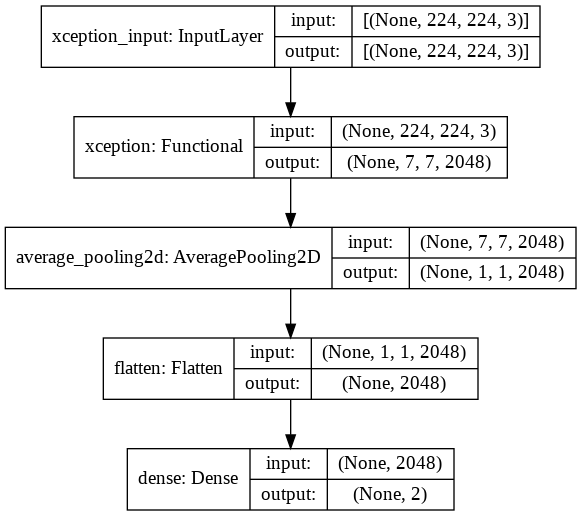

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

Compile Model

In [ ]:
METRICS = [   
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.AUC(name='auc', curve='ROC')]

In [ ]:
early_stopping_monitor = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=3, verbose=0,
    restore_best_weights=True) 

In [ ]:
cross_entropy = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer= optimizer,
    loss = cross_entropy,
    metrics = [METRICS]) #METRICS

In [ ]:
start_time = time.time()

history= model.fit(
    train_ds,
    steps_per_epoch= step_train,
    epochs=20,
    validation_data=val_ds,
    validation_steps= step_val,
    verbose=1)
    # callbacks = [early_stopping_monitor])

final_accuracy = history.history["val_accuracy"][-5:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))
print("TRAINING TIME: ", time.time() - start_time, " sec")


Epoch 1/20
16/16 [==============================] - 1286s 79s/step - loss: 0.6759 - accuracy: 0.5863 - auc: 0.6269 - val_loss: 0.5750 - val_accuracy: 0.7125 - val_auc: 0.7742
Epoch 2/20
16/16 [==============================] - 31s 2s/step - loss: 0.6010 - accuracy: 0.6706 - auc: 0.7351 - val_loss: 0.5511 - val_accuracy: 0.7225 - val_auc: 0.7994
Epoch 3/20
16/16 [==============================] - 32s 2s/step - loss: 0.5838 - accuracy: 0.6881 - auc: 0.7554 - val_loss: 0.5394 - val_accuracy: 0.7350 - val_auc: 0.8167
Epoch 4/20
16/16 [==============================] - 32s 2s/step - loss: 0.5577 - accuracy: 0.7181 - auc: 0.7878 - val_loss: 0.5169 - val_accuracy: 0.7750 - val_auc: 0.8374
Epoch 5/20
16/16 [==============================] - 32s 2s/step - loss: 0.5486 - accuracy: 0.7225 - auc: 0.7955 - val_loss: 0.5094 - val_accuracy: 0.7825 - val_auc: 0.8473
Epoch 6/20
16/16 [==============================] - 31s 2s/step - loss: 0.5310 - accuracy: 0.7369 - auc: 0.8135 - val_loss: 0.4971 - val_

Save Model

In [ ]:
model.save('drive/My Drive/model/Xception20E_FA2.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


dict_keys(['loss', 'accuracy', 'auc', 'val_loss', 'val_accuracy', 'val_auc'])


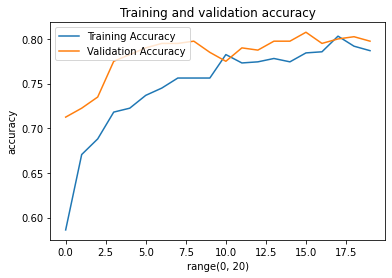

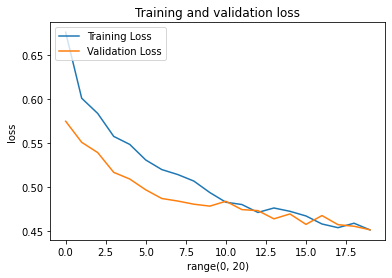

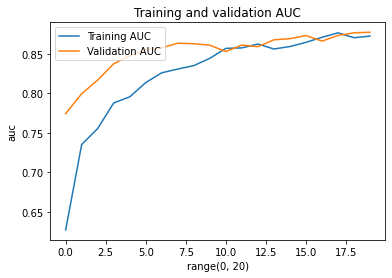

In [ ]:
# list all data in history
print(history.history.keys())
acc = history.history['accuracy']
epochs = range(len(acc))
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs)
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel(epochs)
plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
plt.show()
# summarize history for AUC
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Training and validation AUC')
plt.ylabel('auc')
plt.xlabel(epochs)
plt.legend(['Training AUC', 'Validation AUC'], loc='upper left')
plt.show()


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[166  34]
 [ 47 153]]
Normalized confusion matrix
[[0.83  0.17 ]
 [0.235 0.765]]


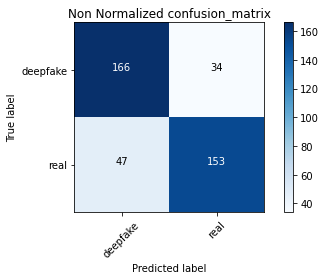

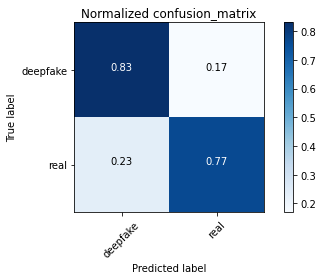

In [ ]:
val_ds.reset()
y_pred = model.predict(val_ds, step_val)
y_pred = np.argmax(y_pred, axis=1)
y_test = val_ds.classes[val_ds.index_array]
cm = confusion_matrix(y_test, y_pred)


labels = list(val_ds.class_indices.keys())
plt.figure()
plot_confusion_matrix(cm=cm, classes=label, title='Non Normalized confusion_matrix')

plt.figure()
plot_confusion_matrix(cm=cm, classes=label, title='Normalized confusion_matrix', normalize=True)

In [ ]:
from sklearn.metrics import classification_report
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.83      0.80       200
           1       0.82      0.77      0.79       200

    accuracy                           0.80       400
   macro avg       0.80      0.80      0.80       400
weighted avg       0.80      0.80      0.80       400



In [ ]:
# hhh

In [ ]:
# Data generators
train_dsgen = ImageDataGenerator( preprocessing_function=pir,
                                  horizontal_flip = True,
                                  vertical_flip = True)

# Note that the validation data should not be augmented!
val_dsgen = ImageDataGenerator(preprocessing_function=pir)


In [ ]:

train_ds = train_dsgen.flow_from_directory(
        # This is the target directory
        train_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)

val_ds = val_dsgen.flow_from_directory(
        validation_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [ ]:
base_modelr = tf.keras.applications.ResNet50(
    weights="imagenet",                   # Load weights pre-trained on ImageNet.
    input_shape=(img_height,img_width,3),
    include_top=False) 
#base_model.summary()

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
base_modelr.trainable = False

In [ ]:
modelr = Sequential()
modelr.add(base_modelr)
modelr.add(AveragePooling2D(pool_size=(7,7)))
modelr.add(Flatten())
modelr.add(Dense(2, activation='softmax'))

modelr.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
average_pooling2d_2 (Average (None, 1, 1, 2048)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
cross_entropy = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
modelr.compile(optimizer= optimizer,
    loss = cross_entropy,
    metrics = [METRICS]) #METRICS

In [ ]:
start_time = time.time()

historyresnet50 = modelr.fit(
    train_ds,
    steps_per_epoch= step_train,
    epochs=20,
    validation_data=val_ds,
    validation_steps= step_val,
    verbose=1)
    # callbacks = [early_stopping_monitor])

final_accuracy = historyresnet50.history["val_accuracy"][-5:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))
print("TRAINING TIME: ", time.time() - start_time, " sec")

Epoch 1/20
16/16 [==============================] - 19s 963ms/step - loss: 1.1988 - accuracy: 0.5590 - auc: 0.5515 - val_loss: 0.8864 - val_accuracy: 0.4625 - val_auc: 0.4663
Epoch 2/20
16/16 [==============================] - 14s 888ms/step - loss: 0.8570 - accuracy: 0.5181 - auc: 0.5092 - val_loss: 0.8942 - val_accuracy: 0.5000 - val_auc: 0.4945
Epoch 3/20
16/16 [==============================] - 14s 870ms/step - loss: 0.7852 - accuracy: 0.5494 - auc: 0.5583 - val_loss: 0.8048 - val_accuracy: 0.5150 - val_auc: 0.5262
Epoch 4/20
16/16 [==============================] - 14s 866ms/step - loss: 0.7495 - accuracy: 0.5525 - auc: 0.5780 - val_loss: 0.7700 - val_accuracy: 0.5400 - val_auc: 0.5633
Epoch 5/20
16/16 [==============================] - 14s 867ms/step - loss: 0.7271 - accuracy: 0.5769 - auc: 0.5972 - val_loss: 0.7320 - val_accuracy: 0.5700 - val_auc: 0.6005
Epoch 6/20
16/16 [==============================] - 14s 893ms/step - loss: 0.6991 - accuracy: 0.5969 - auc: 0.6308 - val_loss

In [ ]:
modelr.save('drive/My Drive/model/Resnet20E_FA2.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


dict_keys(['loss', 'accuracy', 'auc', 'val_loss', 'val_accuracy', 'val_auc'])


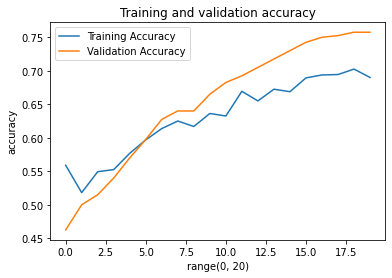

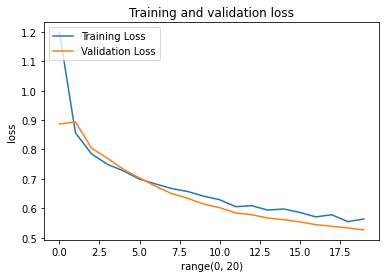

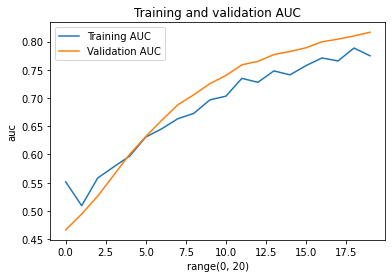

In [ ]:
# list all data in history
print(historyresnet50.history.keys())
acc = historyresnet50.history['accuracy']
epochs = range(len(acc))
# summarize history for accuracy
plt.plot(historyresnet50.history['accuracy'])
plt.plot(historyresnet50.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs)
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(historyresnet50.history['loss'])
plt.plot(historyresnet50.history['val_loss'])
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel(epochs)
plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
plt.show()
# summarize history for AUC
plt.plot(historyresnet50.history['auc'])
plt.plot(historyresnet50.history['val_auc'])
plt.title('Training and validation AUC')
plt.ylabel('auc')
plt.xlabel(epochs)
plt.legend(['Training AUC', 'Validation AUC'], loc='upper left')
plt.show()

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[136  64]
 [ 33 167]]
Normalized confusion matrix
[[0.68  0.32 ]
 [0.165 0.835]]


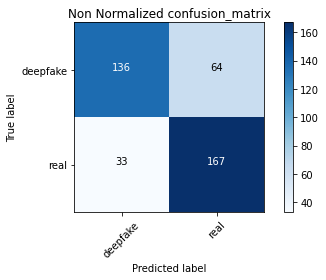

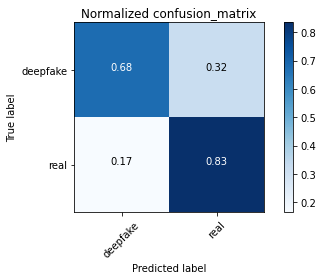

In [ ]:
val_ds.reset()
y_pred = modelr.predict(val_ds, step_val)
y_pred = np.argmax(y_pred, axis=1)
y_test = val_ds.classes[val_ds.index_array]
cm = confusion_matrix(y_test, y_pred)


labels = list(val_ds.class_indices.keys())
plt.figure()
plot_confusion_matrix(cm=cm, classes=label, title='Non Normalized confusion_matrix')

plt.figure()
plot_confusion_matrix(cm=cm, classes=label, title='Normalized confusion_matrix', normalize=True)

dict_keys(['loss', 'accuracy', 'auc', 'val_loss', 'val_accuracy', 'val_auc'])


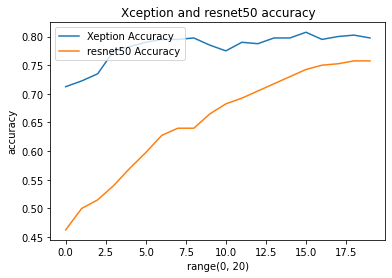

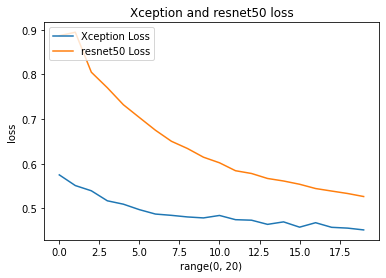

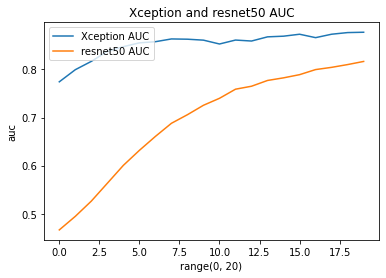

In [ ]:
# list all data in history
print(historyresnet50.history.keys())
acc = historyresnet50.history['accuracy']
epochs = range(len(acc))
# summarize history for accuracy
plt.plot(history.history['val_accuracy'])
plt.plot(historyresnet50.history['val_accuracy'])
plt.title('Xception and resnet50 accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs)
plt.legend(['Xeption Accuracy', 'resnet50 Accuracy'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['val_loss'])
plt.plot(historyresnet50.history['val_loss'])
plt.title('Xception and resnet50 loss')
plt.ylabel('loss')
plt.xlabel(epochs)
plt.legend(['Xception Loss', 'resnet50 Loss'], loc='upper left')
plt.show()
# summarize history for AUC
plt.plot(history.history['val_auc'])
plt.plot(historyresnet50.history['val_auc'])
plt.title('Xception and resnet50 AUC')
plt.ylabel('auc')
plt.xlabel(epochs)
plt.legend(['Xception AUC', 'resnet50 AUC'], loc='upper left')
plt.show()

Evaluasi

In [ ]:
from sklearn.metrics import classification_report
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.68      0.74       200
           1       0.72      0.83      0.77       200

    accuracy                           0.76       400
   macro avg       0.76      0.76      0.76       400
weighted avg       0.76      0.76      0.76       400

